# Discrete convolution filters

In both of the previous parts, each output pixel depends on a single point in the input: for pointwise operations it's exactly the corresponding pixel, whereas for image 
warping the source locations come from a more arbitrary mapping.  For other kinds of operations we need output pixels to depend on a *neighborhood* in the input, and convolution is the canonical example.

In this part we will implement convolution with arbitrary 2D filters and with separable 2D filters.  Take a moment to review the convolution lecture, which explains exactly how this operation works. The basic tasks are:

* generate a Gaussian filter
* implement a general convolution
* implement separable filtering and time it against the general implementation
* do sharpening with the unsharp mask

First, we import a few libraries to be used:

In [3]:
import math
import numpy as np
from PIL import Image
from IPython.display import display
from ipywidgets import interact

In [4]:
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt

And let's load an image so we have something to filter:

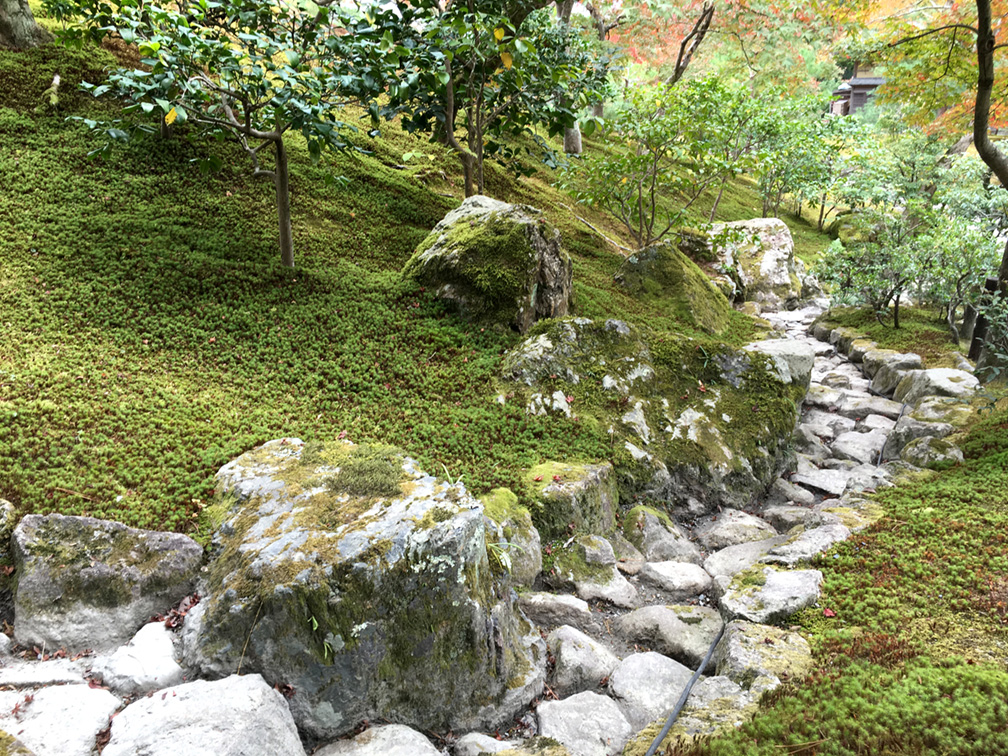

In [5]:
im = im_full = np.array(Image.open('inputs/Kinkaku-ji.jpg'))
ref_size = 'large'
display(Image.fromarray(im))

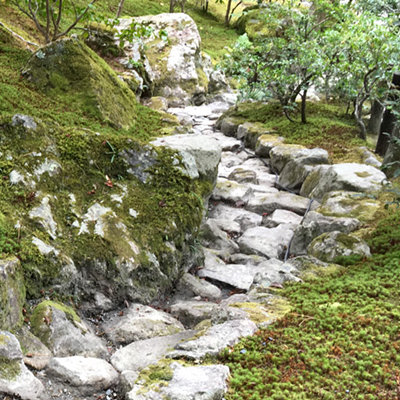

In [6]:
# Smaller image for testing slower implementations
im = im_full[205:605,593:993]; ref_size = 'medium'
# Skip this cell to work with the full image...
# Or uncomment this for an even smaller size...
#im = im_full[209:409,717:917]; ref_size = 'small'
display(Image.fromarray(im))

## Starter example: box blur

The simplest way to blur an image is using a box filter; as explained in lecture, this amounts to replacing each pixel with the average of the pixels in an area around it.  Here is a very simple implementation for a box filter of size $2r+1 \times 2r+1$, using [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) to compute the average.

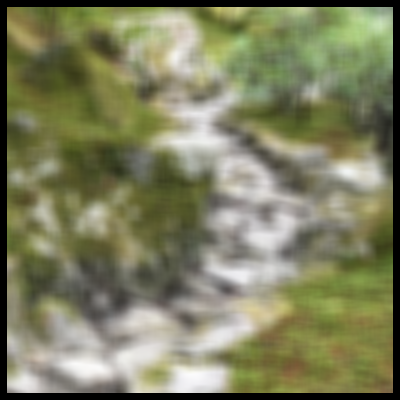

CPU times: user 3.17 s, sys: 33.8 ms, total: 3.21 s
Wall time: 3.26 s


In [7]:
%%time
r = 7
box_blur = np.zeros_like(im)
for i in range(r, im.shape[0] - r):
    for j in range(r, im.shape[1] - r):
        box_blur[i,j] = np.mean(im[i-r:i+r+1,j-r:j+r+1,:], (0,1))
display(Image.fromarray(box_blur))

Note that I skipped computing the edges so as not to have to worry about out-of-bounds indexing (but you should compute all the way to the edge in your implementations below).  A couple of questions about this code:

* Why does it say `r+1` where it does?
* Why did I have to pass the second argument to `np.mean`?  What happens if it's omitted?

Play around with this for different amounts of blur (different values of `r`).  It does work, but it does produce some kind of grid-aligned structures in the blurred image, almost as if it was photographed through a window screen.  It also gets slow because it does an amount of computation quadratic in `r`.

If you think about this computation, there is something very wasteful about it: neighboring pixels in the output are averages of overlapping areas of the input, but we are computing the averages afresh every time.  Another way to approach this is to compute the averages along columns, then along rows.  (We discussed this in lecture under the name "separable convolution.")

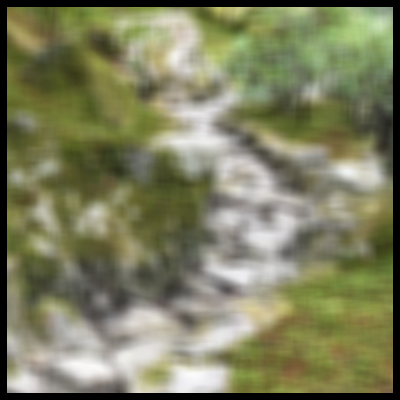

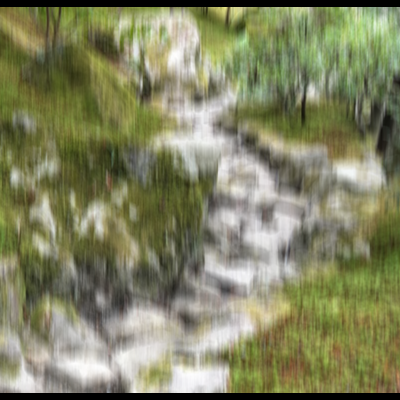

CPU times: user 4.75 s, sys: 79.1 ms, total: 4.83 s
Wall time: 4.91 s


In [8]:
%%time
r = 7
temp = np.zeros_like(im)
for i in range(r, im.shape[0] - r):
    for j in range(im.shape[1]):
        temp[i,j] = np.mean(im[i-r:i+r+1,j,:], 0)
box_blur2 = np.zeros_like(im)
for i in range(im.shape[0]):
    for j in range(r, im.shape[1] - r):
        box_blur2[i,j] = np.mean(temp[i,j-r:j+r+1,:], 0)
display(Image.fromarray(box_blur2))
display(Image.fromarray(temp))

This approach computes the same result, and it is slower for small filters (because two passes involve more overhead), but for large filters it gets faster (it wins handily by $r = 30$ for me).  A couple questions to think about:

* Why did I need different bounds on the loops this time?
* What is in that `temp` image?  Why does it look like that?
* What does the `temp` image look like if I blur along `j` first, then `i`?

## Generate a Gaussian filter

A nicer blur would be a weighted average that decays more gradually with distance, rather than just cutting off at the edge of the box.  It also would be nice if it was isotropic: it should assign pixels at the same distance the same weight.  And it would be nice if it was separable so that we could use that speedy trick to save computing cycles.  It turns out that once we demand all these things we have pretty much narrowed down the filter we want: it is a Gaussian function of the form

\\[g(x,y) = C e^{-kr^2} = C e^{-k(x^2+y^2)} = C e^{-kx^2} e^{-ky^2}\\]

for some positive constants $C$ and $k$.  You can tell it is isotropic because it is a function of distance ($x^2+y^2$ is squared distance), and it is also separable because the sum in the exponent allows the exponential part to be written as a product of functions of $x$ and $y$.  And it decays with distance as long as $k$ is positive. 

This function is known as a Gaussian, and it's the same kind of function that defines the familiar Normal distribution in statistics.

The usual convention for choosing the constants $C$ and $k$ is to use one parameter called $\sigma$, which is the standard deviation if this function is used to define a probability distribution, and normalize it so that its integral is $1$, leading to the [canonical](https://en.wikipedia.org/wiki/Gaussian_filter) form:

\\[g(x,y)=\frac{1}{2\pi\sigma^2}e^{-(x^2+y^2)/(2\sigma^2)}\\]

In order to use a Gaussian as a convolution filter, we need to discretize it as an array of weights.  So your first task is to write a function that will generate a Gaussian blur filter with a given dimension and standard deviation.  When you implement this you don't need to worry about the normalization constant, since you will want to normalize the discrete filter after you've computed it.

For odd-numbered dimensions, the center pixel in the filter is considered zero offset (i.e. the filter is centered in the middle), and for even-numbered dimensions, the zero offset is half a pixel to the positive side.  For example, a 7x7 filter will have the gaussian centered at (3,3), but 8x8 and 9x9 will both have it centered at (4,4).

**Note: You must implement this function from scratch. This means you cannot use functions like scipy.ndimage.gaussian_filter or similar functions from other libraries.**

In [9]:
# Input:
#   dim: size of the filter in both x and y direction
#   sigma: standard deviation of the gaussian filter
# Output:
#   A 2-dimensional numpy array of size dim*dim
#   (Note that the array should be normalized)
# Hint: Use linspace or mgrid from numpy
def gen_gaussian_filter(dim, sigma):
    # A3TODO: Complete this function
    center = dim // 2
    
    f = np.zeros([dim, dim])
    for i in range(0, dim):
        for j in range(0, dim):
            f[i,j] = np.exp(-((i-center)**2 + (j-center)**2)/(2* sigma**2))
    
    return f / (2 * np.pi * sigma**2)

# testing
f = gen_gaussian_filter(7,1)

When you call this function you generally want the dimension to be big enough that the weights have dropped near zero by the time they get clipped at the edge of the filter.  A safe rule is to make the radius of the filter at least $3\sigma$.  The following should show you a filter that has a peak value of 0.159 at the center and drops to 0.00177 at the edges and 1.97e-5 at the corners.

<IPython.core.display.Javascript object>


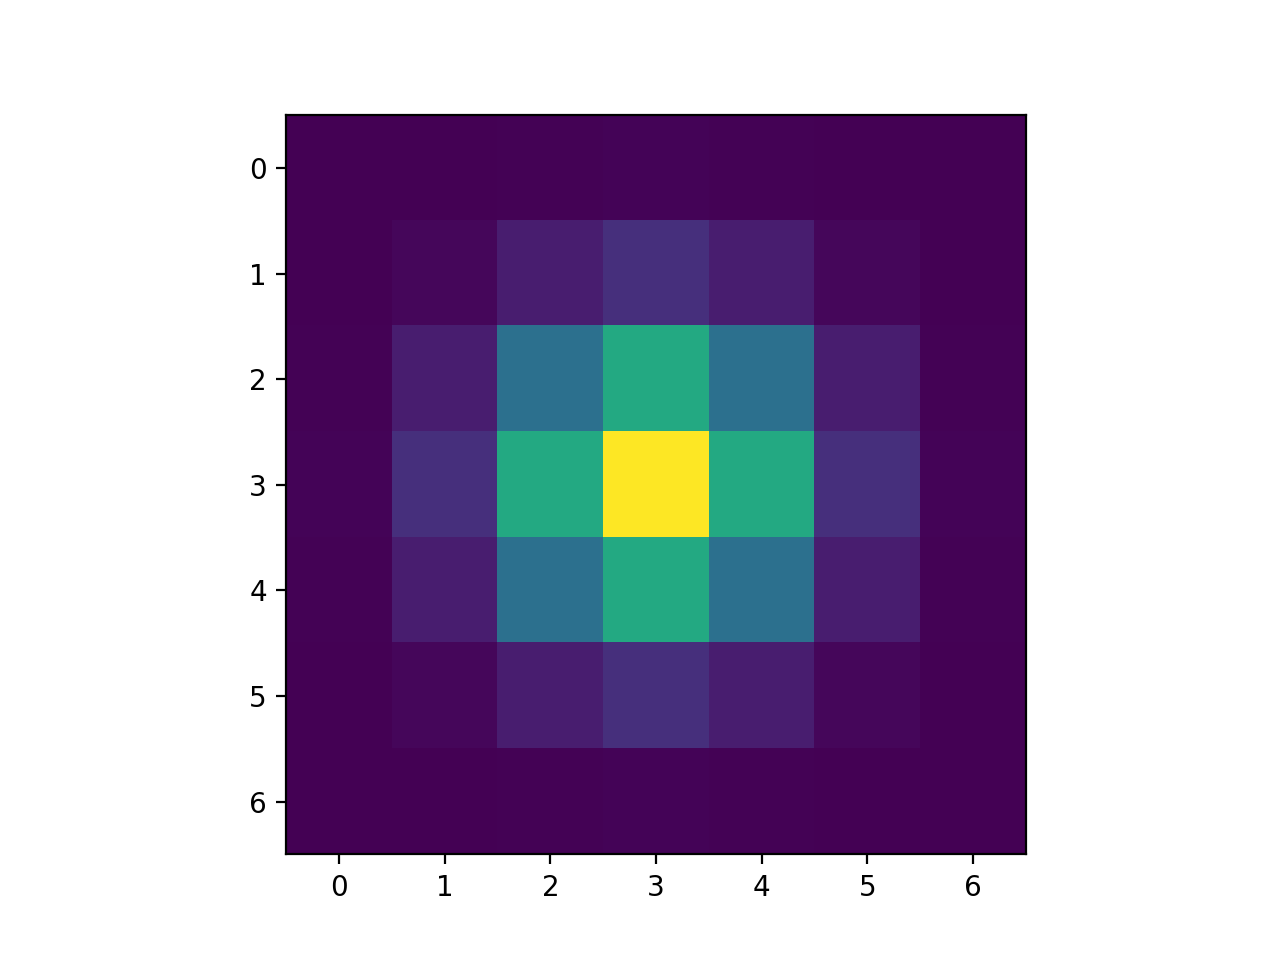

In [10]:
plt.figure()
plt.imshow(gen_gaussian_filter(7, 1))

### General convolution

Now that you have a way to get a filter, write a function that will take a filter and an image and return the filtered image.

Please follow Slide 14 in the lecture on discrete convolution filters for the implementation.
Your code should work for both square and non-square filters, with odd or even numbered dimensions.
The centering of the filter is the same as for the filter generation.

**Note: You must implement this function from scratch. This means you cannot use functions like scipy.ndimage.convolve or similar functions from other libraries.**

[I'm not sure this is tested for non-square or even sizes or for non-symmetric filters.]

In [11]:
# Input:
#   I: A 2D numpy array containing pixels of an image
#   f: A squared/non-squared filter of odd/even-numbered dimensions
# Output:
#   A 2D numpy array resulting from applying the convolution filter f to I
#   All the entries of the array should be of type uint8, and restricted to [0,255]
#   You may use clip and astype in numpy to enforce this
# Note: When convolving, do not operate on the entries outside of the image bound,
#           i.e. clamp the ranges to the width and height of the image
#       Tie-breaking: If f has an even number of dimensions in some direction (assume the dimension is 2r),
#           sweep through [i-r+1, i+r] (i.e. length of left half = length of right half - 1)
#           With odd # of dimensions (2r+1), you would sweep through [i-r, i+r].
def convolve(I, f):
    output = np.zeros_like(I).astype(np.uint8)
    image_height = I.shape[0]
    image_length = I.shape[1]
    r = (f.shape[0] - 1) // 2
    
    pad_I = np.zeros((image_height+2*r, image_length+2*r))
    pad_I[r:(image_height+r), r:(image_length+r)] = I
    
    for p in range(0, image_length):
        for q in range(0, image_height):
            
            s = 0        
            for i in range(-r, r):
                for j in range(-r, r): 
                    s = s + f[j][i] * pad_I[q+r-j][p+r-i]
            output[q][p] = s
            
    return output.astype(np.uint8) / 255

In [12]:
%%time
blurred = convolve(im, gen_gaussian_filter(7, 1.0))
ref_blurred = np.array(Image.open('./reference/convolution-reference-{0}.png'.format(ref_size)))
print("Image is same as reference: ", np.array_equal(ref_blurred, blurred))
display(Image.fromarray(blurred))

ValueError: could not broadcast input array from shape (400,400,3) into shape (400,400)

## Separable filtering

Just as in the box example above, and as explained in the lecture, the separability of the Gaussian filter means the filtering operation can be done more efficiently in two passes.  Make another implementation of the convolution operation that assumes the filter is separable (so you only need to pay attention to the center row or column of the filter) and computes a result that matches the 2D convolution but faster.

In [61]:
# Input:
#   I: A 2D numpy array containing pixels of an image
#   f: A squared/non-squared filter of odd/even-numbered dimensions
# Output:
#   A 2D numpy array resulting from applying the convolution filter f to I
#   All the entries of the array should be of type uint8, and restricted to [0,255]
#   You may use clip and astype in numpy to enforce this
# Note: When convolving, do not operate on the entries outside of the image bound,
#           i.e. clamp the ranges to the width and height of the image in the for loop
#       Tie-breaking: If f has an even number of dimensions in some direction (assume the dimension is 2r),
#           sweep through [i-r+1, i+r] (i.e. length of left half = length of right half - 1)
#           With odd # of dimensions (2r+1), you would sweep through [i-r, i+r].
#       You will convolve with respect to the direction corresponding to I.shape[0] first, then I.shape[1]
def convolve_sep(I, f):
    output = np.zeros_like(I)
        
    # A3TODO: Complete this function
    
    return output

Max difference from 2D convolution: 0


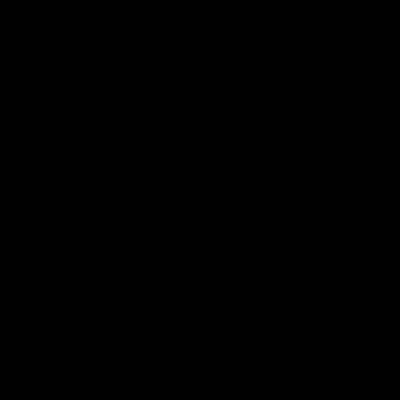

CPU times: user 11.7 ms, sys: 7.7 ms, total: 19.4 ms
Wall time: 20.2 ms


In [62]:
%%time
blurred2 = convolve_sep(im, gen_gaussian_filter(7, 1.0))

print("Max difference from 2D convolution:", np.amax(np.abs(blurred2.astype(int) - blurred.astype(int))))
display(Image.fromarray(blurred2))

## Unsharp mask

A simple and useful application of gaussian blur is a sharpening technique called *unsharp mask*.  The idea is to compute a blurred image and then make a sharpened image that is a convex linear combination of the original image
and the blurred image, with a negative weight on the blurred image:

\\[O = (1+w) I - w\, \text{blur}(I)\\]

Implement an unsharp masking operation in the following function, which takes the $\sigma$ for the blurring filter and the weight $w$ for the equation above.  Use a filter with a radius of 3 times the standard deviation (rounded up to the nearest integer).  This operation can produce pixel values outside the range $[0,255]$ which you'll need to clamp.

In [ ]:
# This function essentially subtracts a (scaled) blurred version of an image from (scaled version of) itself
# Input:
#   I: A 2D numpy array containing pixels of an image
#   sigma: Gassian std.dev. for blurring
#   w: Sharpening weight
# Output:
#   A sharpened version of I
def unsharp_mask(I, sigma, w):
    # A3TODO: Complete this function
    output = np.zeros_like(I)

    return output

In this cell you can try it out for different parameters.  Larger blurs and higher weights both lead to stronger sharpening; the parameters $\sigma=1.5, w=0.5$ work pretty well for the example image.

In [ ]:
sharpened = unsharp_mask(im, 1.5, 0.5)
ref_sharpened = np.array(Image.open('./reference/sharpened-reference-{0}.png'.format(ref_size)))
print("Image is same as reference: ", np.array_equal(ref_sharpened, sharpened))
display(Image.fromarray(sharpened))

The effects of sharpening can be a little subtle, so here is a cell to compare the original image to the filtered versions:

In [ ]:
interact(
    lambda mode: display(Image.fromarray(
        {0: im, 1: blurred, 2: sharpened}[mode])),
    mode=[('original', 0), ('blurred', 1), ('sharpened', 2)]
)